In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as itr
import time
import csv
import networkx as nx

G = nx.Graph()

This is supplementary code written by Barry O'Donnell in October 2021 for module AM4065.

The code supports a project focused on the Travelling Salesman Problem (TSP) and the algorithms of finding the shortest path.

In [2]:
def GetRandomArray(n, seed=None):
    """
    Creates weighted (n x n) array with no self loops
    IN:  n := int, amount of nodes
         seed := int, seed for random generation
    
    OUT: arr := numpy array, weighted network
    """

    if seed != None:
        np.random.seed(seed)
    
    arr = np.random.randint(1, 5, (n,n))
    np.fill_diagonal(arr, 0)

    return arr * arr.T


def GetCost(arr, i, j):
    """
    Return cost of travelling from 'i' node to 'j' node
    IN:  arr := numpy array, weighted network
         i := int, node i
         j := int, node j
    
    OUT: cost := int, weight of edge{i,j}
    """
    
    return arr[i][j]


def GetPathCost(arr, start, path):
    """
    Return cost of travelling along path [start, j, ... , k]
    IN:  arr := numpy array, weighted network
         start := int, start node for path
         path := list/numpy array of int, path along which you travel through the array
    
    OUT: cost := int, weight of path [start, j, .... , k]
    """
    
    cost = 0
    for i in range(len(path)):
        cost += GetCost(arr, start, path[i])
        start = path[i]
    
    return cost


def GetPathsCost(arr, start, paths):
    """
    Return cost of travelling along paths ie, [start, j, ... , k], [start, k, ... , i], etc.
    IN:  arr := numpy array, weighted network
         start := int, start node for path
         paths := list of lists/numpy arrays of int, paths along which you travel through the array
    
    OUT: costs := numpy array of int, weight of paths, [start, j, ... , k], [start, k, ... , i], etc.
    """
    
    costs = np.zeros(np.shape(paths)[0])
    for i in range(len(paths)):
        costs[i] = GetPathCost(arr, start, paths[i])
    
    return costs


def TSP_performance(algo, n, k=1):
    """
    Finds the computational time of a n node network by some algorithm
    IN:  algo := function, algorithm being analysed
         n := int, nodes
         k := int, for k-NN or ItF algorithm
    
    OUT: time := float, time elapsed while code ran
    """
    
    arr = GetRandomArray(n)
    if algo != TSP_KNN or algo != TSP_ItF:
        start = time.time()
        cost, path = algo(arr)
        end = time.time()
        
    else:
        start = time.time()
        cost, path = algo(arr, k)
        end = time.time()
            
    return end-start


def TSP_avgperform(algo, n=4, k=1, trials=100):
    """
    Finds the average computational time of a n node network by some algorithm
    after some amount of trials.
    IN:  algo := function, algorithm being analysed
         n := int, nodes
         k := int, for k-NN or ItF algorithm
         trials := int, amount of trials
    
    OUT: average comp. time := float, average computational time
    """
    
    avg = 0
    for i in range(trials):
        avg += TSP_performance(algo, n, k)
    
    return avg/trials


def DrawNetwork(arr, save=False, fname="network.pdf", pos = None):
    """
    Draws network for user to see.
    IN:  arr := numpy array, an array representing a network
         save := bool, allows user to save the figure produced
         fname := str, saves the figure with a given name
         pos := dict, allows user to choose the positions of nodes
                 in the figure
                 
    OUT: figure representing the network arr
    """
    
    ## Creates network G from arr
    G = nx.from_numpy_matrix(arr)
    
    ## Checks if user put in positions,
    ##  If not, randomly generate some layout.
    if pos == None:
        pos =  nx.spring_layout(G)
    
    ## Begin figure description
    plt.figure(figsize=(10,10)) 
    
    ## Draws network
    nx.draw(G,pos,edge_color='black',width=1,linewidths=1,
            node_size=1000, node_color='black',
            labels={node:node for node in G.nodes()}, font_size=20, font_color='white')

    ## Adds labels to edges
    edge_labels = dict([ ((n1, n2), d['weight']) 
                        for n1, n2, d in G.edges(data=True) ])

    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_color='black', font_size=20)
    
    ## Removes axis
    plt.axis('off')
    
    ## if user made save = True, saves figure
    if save:
        plt.savefig(fname, dpi=300)
        
    ## SHows figure
    plt.show()
    
    
def DrawPath(arr, paths, save=False, fname="network.pdf", pos = None, labels = ["Brute Force", "Nearest Neighbour", "k-Nearest Neighbour"], colors = ['b', 'y', 'r']):
    """
    Draws network for user to see.
    IN:  arr := numpy array, an array representing a network
         paths := list of lists / numpy arrays of ints, paths around the network (Up to 3)
         save := bool, allows user to save the figure produced
         fname := str, saves the figure with a given name
         pos := dict, allows user to choose the positions of nodes
                 in the figure
         labels := list of str, adds labels to the paths (Up to 3)
         colors := list of str, adds colours to the paths (Up to 3)
                 
    OUT: figure representing the network arr, with paths depicted on it.
    """
    ## Creates network G from arr
    G = nx.from_numpy_matrix(arr)
    
    ## Checks if user put in positions,
    ##  If not, randomly generate some layout.
    if pos == None:
        pos =  nx.spring_layout(G)
    
    ## Begin figure description
    plt.figure(figsize=(10,10)) 
       
    ## Draws network
    nx.draw(G,pos,edge_color='black',width=1,linewidths=1,
            node_size=1000, node_color='black',
            labels={node:node for node in G.nodes()}, font_size=20, font_color='white')

    ## Adds labels to edges
    edge_labels = dict([((n1, n2), d['weight'])
                        for n1, n2, d in G.edges(data=True)])

    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_color='black', font_size=20)
    
    ## Removes axis from figure
    plt.axis('off')
    
    ## Creates list to hold edge details
    edges = []
    
    ## Adds paths to network graph
    for path in paths:
        path_edges = [(path[n], path[n+1]) for n in range(len(path)-1)]
        G.add_edges_from(path_edges)
        edges.append(path_edges)
        
    ## linewidths to draw onto graph, first value being the 'bottom' path
    linewidths = [13,9,3]
    for ctr, edgelist in enumerate(edges):
        nx.draw_networkx_edges(G, pos=pos, edgelist=edgelist, edge_color = colors[ctr], width=linewidths[ctr], label=labels[ctr])
    plt.legend(loc='best')
    
    ## If sve = True, saves figure for user
    if save:
        plt.savefig(fname, dpi=300)
        
    ## Shows figure
    plt.show()

## Brute Force Algorithm

In [3]:
def GetPaths(n):
    """
    Creates all paths for network of 'n' nodes
    IN:  n := int, amount of nodes
    
    OUT: paths := numpy array, array of all paths 
    """
    
    nodes = np.array([i for i in range(n)][1:])
    return np.array(list(itr.permutations(nodes)))


def TSP_BF_path(arr, path):
    """
    Calculates path cost
    IN:  arr := numpy array, weighted network
         path := numpy array, path through the network
    
    OUT: cost := int, cost of path
    """
    
    cost = 0
    start = 0
    for i in range(len(path)):
        cost += GetCost(arr, start, path[i])
        start = path[i]
    
    cost += GetCost(arr, start, 0)
    return cost


def TSP_BF(arr):
    """
    Brute Force Algorithm
    Finds shortest path through network
    IN:  arr := numpy array, weighted network
    
    OUT: cost := int, cost of the path
         path := numpy array, shortest path through network
    """
    
    paths = GetPaths(len(arr))
    costs = np.zeros(len(paths))
    
    for i in range(len(paths)):
        costs[i] += TSP_BF_path(arr, paths[i])
    
    
    path = np.insert( np.insert(paths[np.argmin(costs)],0,0), len(arr), 0) 
    
    return int(np.min(costs)), path

## Nearest Neighbour Algorithm

In [4]:
def GetMinCost(arr, start, nodes):
    """
    Finds the lowest weighted edge connected to 'start' node
    IN:  arr := numpy array, weighted network
         start := int, node i
         nodes := numpy array, nodes available to start node
         
    OUT: node := int, node with lowest weight connected to 'start' 
         cost := int, cost of edge{i,j}
    """
    
    costs = GetCost(arr, start, nodes)
                
    return nodes[np.argmin(costs)], np.min(costs)


def TSP_NN(arr):
    """
    Nearest Neighbour algorithm.
    Finds path of shortest immediate edges through network
    IN:  arr := numpy array, weighted network
    
    OUT: cost := int, cost of the path
         path := numpy array, NN path through network
    """
    
    n = len(arr)
    costs = 0
    start = 0
    
    path = np.full((len(arr)+1),None)
    path[0] = 0
    
    
    nodes = np.array([i for i in range(n)][1:])
    nodes = nodes[np.isin(nodes, path, invert=True)]
    
    for i in range(1,n):
        
        end, cost = GetMinCost(arr, path[i-1], nodes)
        
        path[i] = end
        nodes = nodes[nodes != end]
        costs += cost
        
    path[-1] = 0
    path = np.array(path, dtype='int')
    costs += GetCost(arr, end, 0)
    
    return int(costs), path


## k-Nearest Neighbour

In [5]:
def GetKPaths(nodes, node, k):
    """
    Creates all paths for network of 'n' nodes
    IN:  node := int, node i
         nodes := numpy array, nodes available to node i within k-steps
         k := int, amount of steps you are looking ahead
    
    OUT: paths := np.array(), array of all paths 
    """
    
    nodes = nodes[nodes != node]
    
    ## Calculates permutations from node i to all available nodes within k-steps
    if k >= len(nodes):
        ## If k >= nodes, then we just need a permutation of all the nodes remaining
        return np.array(list(itr.permutations(nodes, len(nodes))))
    else:
        ## If k < nodes, calculate every permutation of the nodes of length k
        return np.array(list(itr.permutations(nodes, k)))

    
def TSP_KNN(arr, k=1):
    """
    k-Nearest Neighbour
    Finds shortest path through network by observing k-steps ahead
    IN:  arr := np.array(), weighted network
         k := int, amount of steps you are looking ahead.
    
    OUT: cost := int, cost of the path
         path := np.array(), k-NN path through network
    """

    ## Checks that k is >= 1
    if k<1:
        return print("Must enter a value of k >= 1")
    
    nodes = np.array([i for i in range(1, len(arr))])

    start = 0

    path = np.array([start])
    
    ## Begins while loop
    while len(nodes) != 0:
        
        ## Generates possible paths from node i to k-steps away
        kpaths = GetKPaths(nodes, start, k)
        
        ## Calculates cost of path
        costs = GetPathsCost(arr, start, kpaths)
        
        ## If k > the amount of remaining nodes, must account for returning to beginning node
        if k > len(kpaths[0]):
            for i in range(len(kpaths)):
                zero_return = GetCost(arr, kpaths[i][-1], 0)
                costs[i] += zero_return
        
            ## Get minimum path
            minpath = kpaths[np.argmin(costs)]
        
            ## Construct the full path and end the loop
            path = np.append(path, minpath)
            break
                
        ## Get min path
        minpath = kpaths[np.argmin(costs)]
        
        ## Take 1 step forward
        path = np.append(path, minpath[0])
        nodes = nodes[nodes != path[-1]]
        start = path[-1]
        
    ## Append beginning node to path
    path = np.append(path, 0)
    costs = GetPathCost(arr, 0, path)
    
    return int(costs), path

## Into-the-Fray Algorithm

In [6]:
def GetKPaths(nodes, node, k):
    """
    Creates all paths for network of 'n' nodes
    IN:  node := int, node i
         nodes := numpy array, nodes available to node i within k-steps
         k := int, amount of steps you are looking ahead
    
    OUT: paths := np.array(), array of all paths 
    """
    
    nodes = nodes[nodes != node]
    
    ## Calculates permutations from node i to all available nodes within k-steps
    if k >= len(nodes):
        ## If k >= nodes, then we just need a permutation of all the nodes remaining
        return np.array(list(itr.permutations(nodes, len(nodes))))
    else:
        ## If k < nodes, calculate every permutation of the nodes of length k
        return np.array(list(itr.permutations(nodes, k)))


def TSP_ItF(arr, k=1):
    """
    Into-the-Fray
    Finds shortest path through network by observing k-steps ahead
        Is a worse version of KNN in every way
    IN:  arr := np.array(), weighted network
         k := int, amount of steps you are looking ahead.
    
    OUT: cost := int, cost of the path
         path := np.array(), k-NN path through network
    """

    ## Checks that k is >= 1
    if k<1:
        return print("Must enter a value of k >= 1")
    
    nodes = np.array([i for i in range(1, len(arr))])

    start = 0

    path = np.array([start])
    
    ## Begins while loop
    while len(nodes) != 0:
        
        kpaths = GetKPaths(nodes, start, k)
        
        costs = GetPathsCost(arr, start, kpaths)
        
        ## If k > the amount of remaining nodes, must account for returning to beginning node
        if k > len(kpaths[0]):
            for i in range(len(kpaths)):
                zero_return = GetCost(arr, kpaths[i][-1], 0)
                costs[i] += zero_return
        
            ## Get minimum path
            minpath = kpaths[np.argmin(costs)]
        
            ## Construct the full path and end the loop
            path = np.append(path, minpath)
            break
        
        minpath = kpaths[np.argmin(costs)]
        
        ## Jumps to the end of the min cost path
        path = np.append(path, minpath)

        for n in minpath:
            nodes = nodes[nodes != n]
            
        start = path[-1]

    ## Append beginning node to path
    path = np.append(path, 0)
    costs = GetPathCost(arr, 0, path)
    
    return int(costs), path

## If-it-ain't-broke algorithm

In [7]:
def TSP_IiaB(arr):
    """
    If-it-ain't-Broke
    Very simplistic algorithm that travels through the network along [0, 1, 2, ... , n]
    IN:  arr := numpy array, weighted network
    
    OUT: cost := int, cost of the path
         path := numpy array, NN path through network
    """
    
    path = np.array([i for i in range(len(arr))])
    cost = GetPathCost(arr, 0, path[1:])
    
    cost += GetCost(arr, path[-1], 0)
    path = np.append(path, 0)
    
    return int(cost), path

## Example

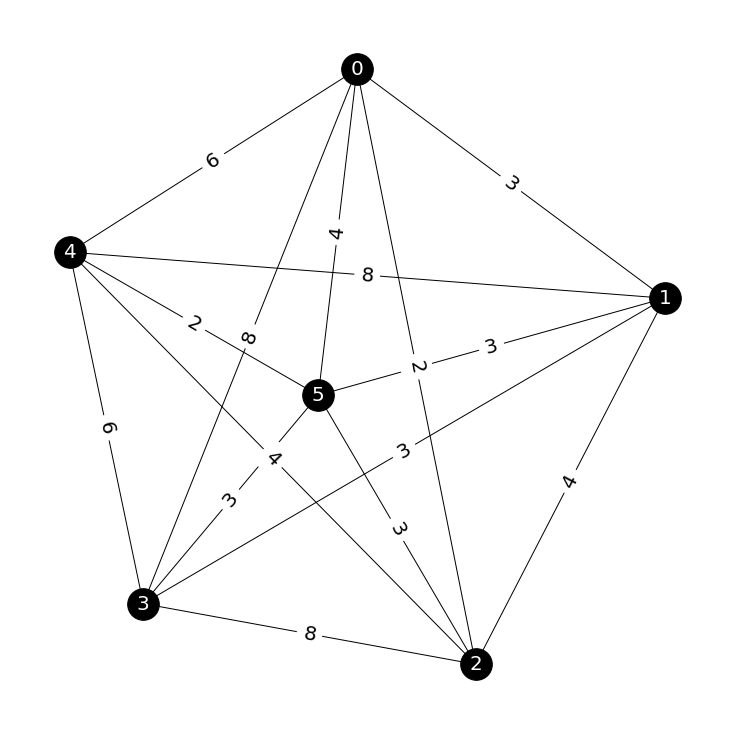

In [8]:
## Toy example using network with n=6 nodes
arr = np.array([[0, 3, 2, 8, 6, 4],
 [3, 0, 4, 3, 8, 3],
 [2, 4, 0, 8, 4, 3],
 [8, 3, 8, 0, 6, 3],
 [6, 8, 4, 6, 0, 2],
 [4, 3, 3, 3, 2, 0]])

pos = {0: np.array([0.05763901, 0.85264863]),
 1: np.array([1.        , 0.22539623]),
 2: np.array([ 0.42116974, -0.77775065]),
 3: np.array([-0.59645827, -0.61144073]),
 4: np.array([-0.82176077,  0.35161524]),
 5: np.array([-0.0605897 , -0.04046871])}

## Displays network for user
DrawNetwork(arr, save = True, pos=pos)

Brute force algorithm: The cost of the shortest path [0 1 3 5 4 2 0] is 17


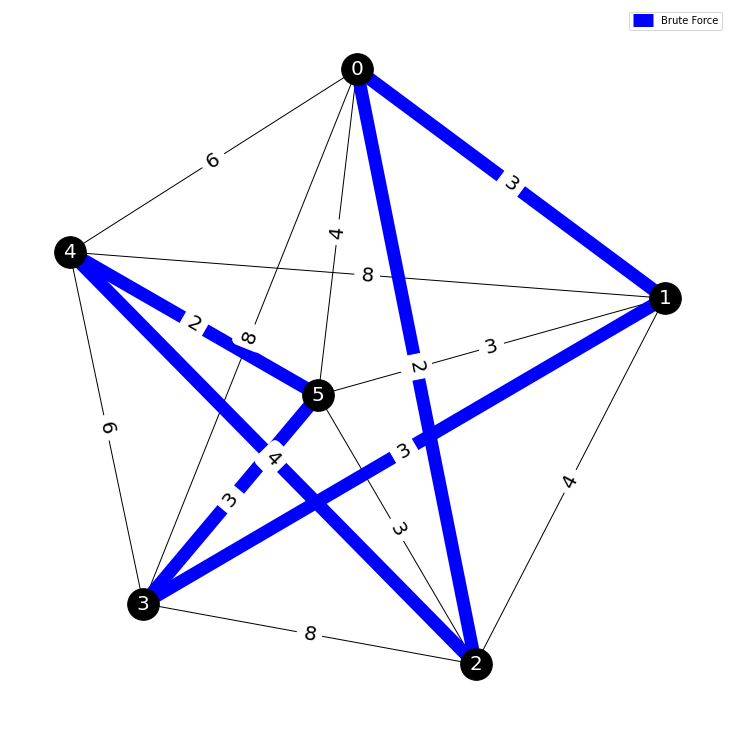

In [9]:
BF = TSP_BF(arr)
print("Brute force algorithm: The cost of the shortest path {} is {}".format(BF[1], BF[0]))
DrawPath(arr, [BF[1]], save=True, fname="bf_network.pdf", pos=pos)

Nearest neighbour algorithm: The cost of the path [0 2 5 4 3 1 0] is 19


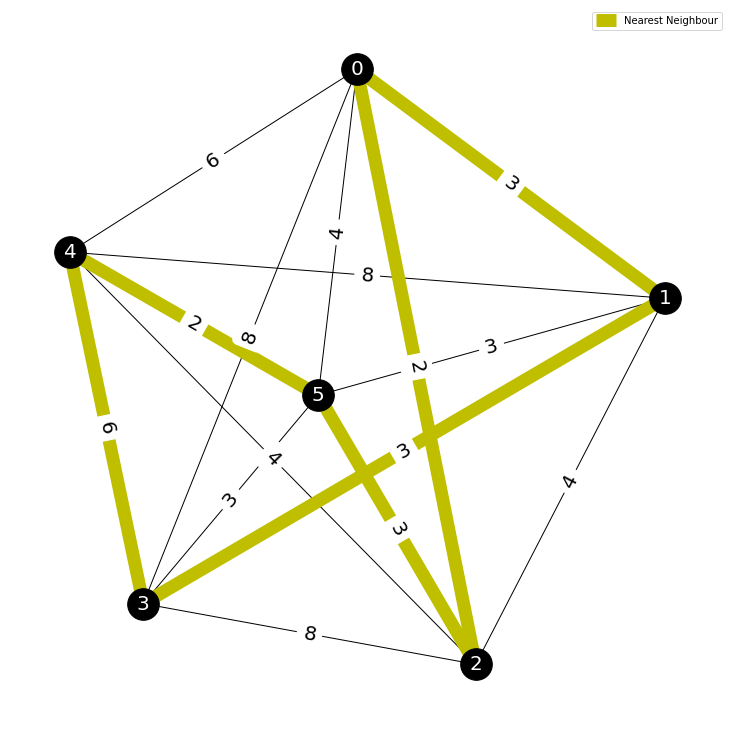

In [10]:
NN = TSP_NN(arr)
print("Nearest neighbour algorithm: The cost of the path {} is {}".format(NN[1], NN[0]))
DrawPath(arr, [NN[1]], save=True, fname="nn_network.pdf", labels=["Nearest Neighbour"], colors=['y'], pos = pos)

k-Nearest neighbour algorithm: The cost of the path [0 2 1 3 5 4 0] is 20


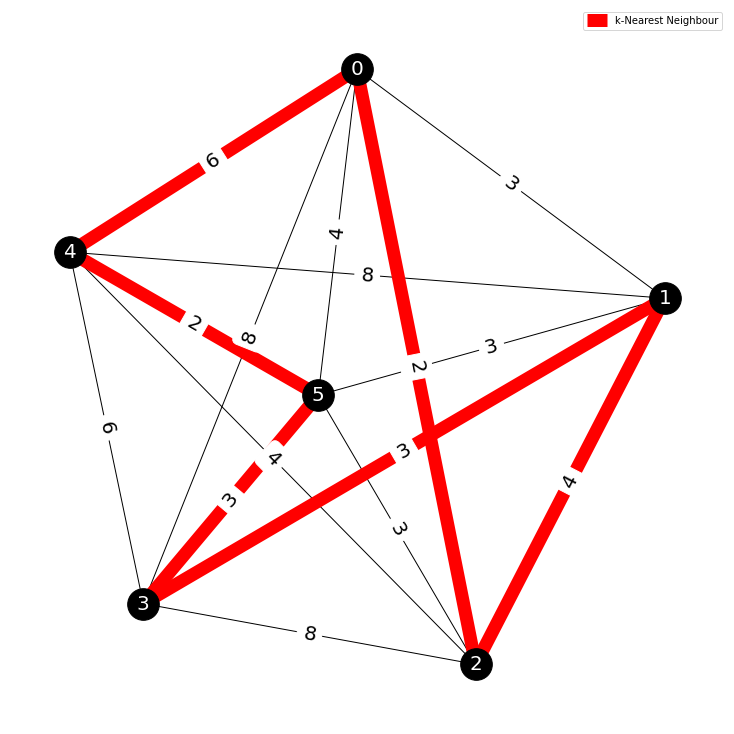

In [11]:
KNN = TSP_KNN(arr,k=3)
print("k-Nearest neighbour algorithm: The cost of the path {} is {}".format(KNN[1], KNN[0]))
DrawPath(arr, [KNN[1]], save=True, fname="knn_network.pdf", labels=["k-Nearest Neighbour"], colors=['r'], pos=pos)

ItF algorithm: The cost of the path [0 2 5 1 3 4 0] is 23


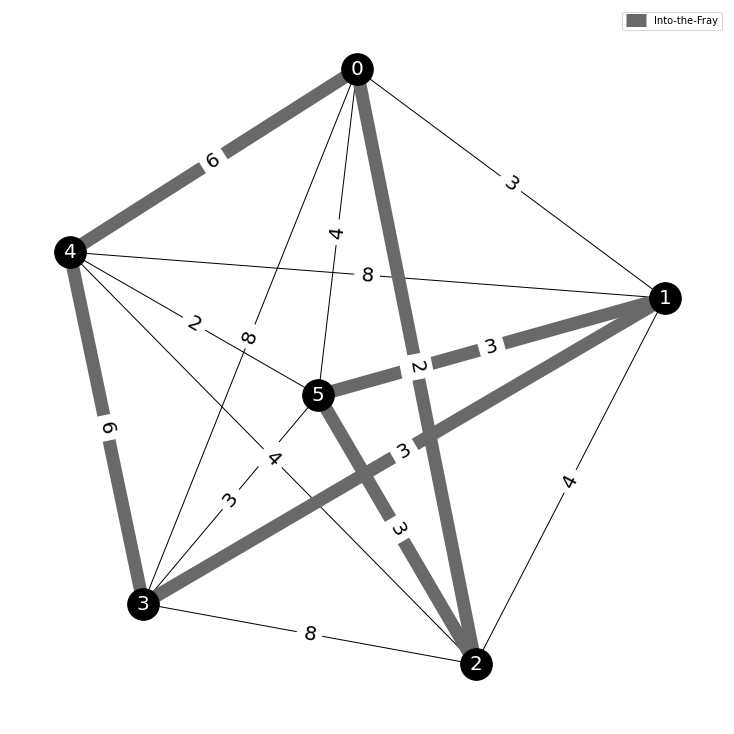

In [12]:
ItF = TSP_ItF(arr,k=2)
print("ItF algorithm: The cost of the path {} is {}".format(ItF[1], ItF[0]))
DrawPath(arr, [ItF[1]], save=True, fname="itf_network.pdf", labels=["Into-the-Fray"], colors=['dimgray'], pos=pos)

IiaB algorithm: The cost of the shortest path [0 1 2 3 4 5 0] is 27


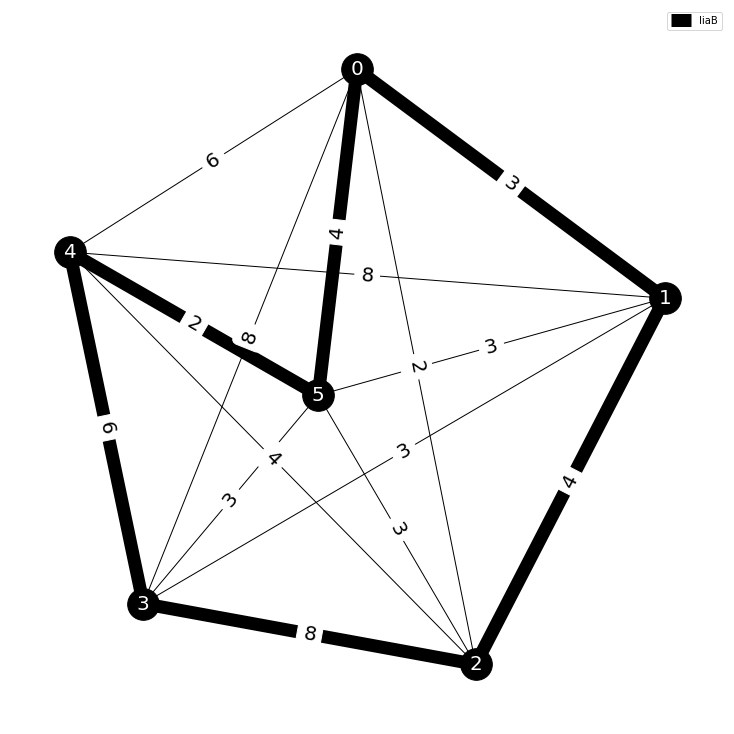

In [13]:
IiaB = TSP_IiaB(arr)
print("IiaB algorithm: The cost of the shortest path {} is {}".format(IiaB[1], IiaB[0]))
DrawPath(arr, [IiaB[1]], labels=['IiaB'], save=True, fname="iiab_network.pdf", pos=pos, colors=['k'])

[[0 3 2 8 6 4]
 [3 0 4 3 8 3]
 [2 4 0 8 4 3]
 [8 3 8 0 6 3]
 [6 8 4 6 0 2]
 [4 3 3 3 2 0]]
Brute force algorithm: The cost of the shortest path [0 1 3 5 4 2 0] is 17
Nearest neighbour algorithm: The cost of the path [0 2 5 4 3 1 0] is 19
k-Nearest neighbour algorithm: The cost of the path [0 2 1 3 5 4 0] is 20


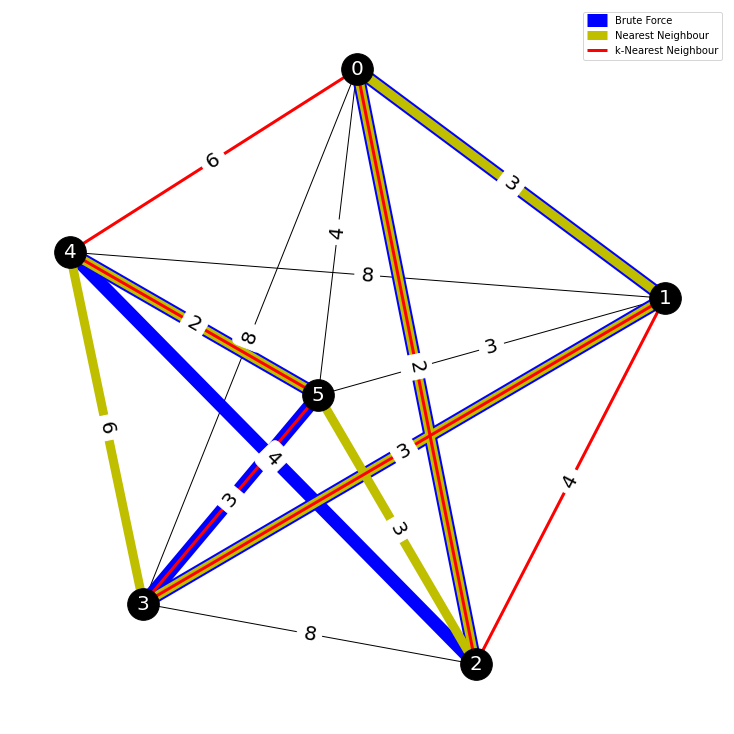

In [14]:
print(arr)
k=3
BF = TSP_BF(arr)
NN = TSP_NN(arr)
KNN = TSP_KNN(arr,k)

## Shows user the cost of the path found by each network
print("Brute force algorithm: The cost of the shortest path {} is {}".format(BF[1], BF[0]))
print("Nearest neighbour algorithm: The cost of the path {} is {}".format(NN[1], NN[0]))
print("k-Nearest neighbour algorithm: The cost of the path {} is {}".format(KNN[1], KNN[0]))

DrawPath(arr, [BF[1], NN[1], KNN[1]], save=True, fname="network_algo.pdf", pos=pos)

## Firing Range

[[ 0 12  9  4  4  8]
 [12  0 12  4  6  9]
 [ 9 12  0  1 16  6]
 [ 4  4  1  0 12  4]
 [ 4  6 16 12  0  3]
 [ 8  9  6  4  3  0]]
Brute force algorithm: The cost of the shortest path [0 4 1 3 2 5 0] is 29
Nearest neighbour algorithm: The cost of the path [0 3 2 5 4 1 0] is 32
k-Nearest neighbour algorithm: The cost of the path [0 3 2 5 1 4 0] is 30


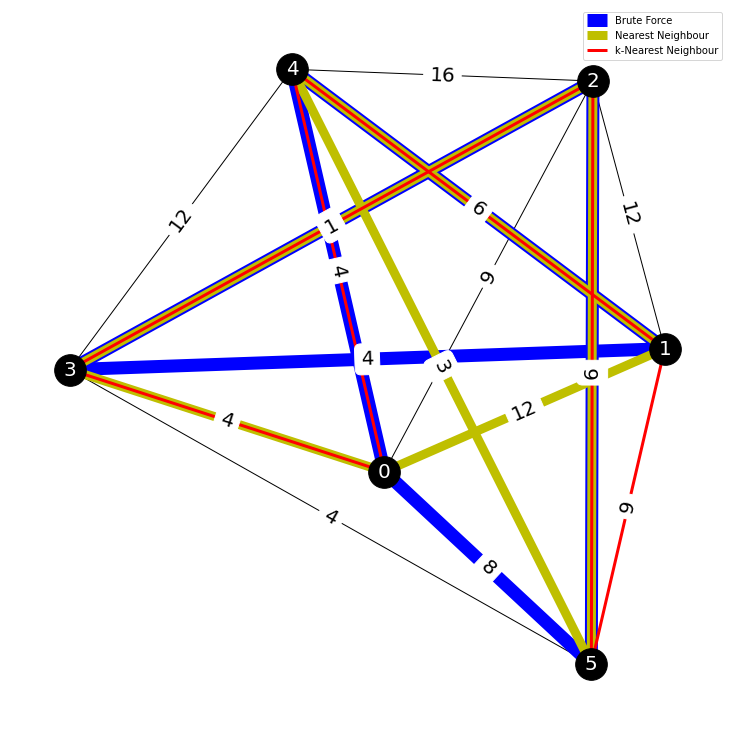

In [15]:
## Testing Random Arrays
n = 6
k = 3
arr = GetRandomArray(n, 4065)

print(arr)

BF = TSP_BF(arr)
NN = TSP_NN(arr)
KNN = TSP_KNN(arr,k)

## Shows user the cost of the path found by each network
print("Brute force algorithm: The cost of the shortest path {} is {}".format(BF[1], BF[0]))
print("Nearest neighbour algorithm: The cost of the path {} is {}".format(NN[1], NN[0]))
print("k-Nearest neighbour algorithm: The cost of the path {} is {}".format(KNN[1], KNN[0]))


if NN[0] == BF[0]:
    print("Nearest neighbour guessed the correct shortest path!")
    
if KNN[0] == BF[0]:
    print("k-Nearest neighbour guessed the correct shortest path!")

DrawPath(arr, [BF[1], NN[1], KNN[1]])

In [25]:
## !!!WARNING!!! INCREASING n to > 12 may cause memory problems and/or result in
##  a computer crash. Use at ones own discretion

## Obtains a frequency array of correct guesses made by KNN
n = 10
nstart = 4
nrange = n - (nstart-1)

model_names = ['KNN (k=n-1)', 'KNN (k=n-2)', 'KNN (k=n-3)', 'NN', 'ItF (k=n-1)', 'ItF (k=n-2)', 'ItF (k=n-3)', 'IiaB', ]
models = len(model_names)

## Attempt 50 trials
trials = 100
errors = np.zeros((nrange, models, trials))


for i in range(nstart, n+1):
    
    for j in range(trials):
        arr = GetRandomArray(i)

        BF = TSP_BF(arr)

        NN = TSP_NN(arr)
        IiaB = TSP_IiaB(arr)

        errors[i-nstart,3,j] = (BF[0] - NN[0]) / BF[0]
        errors[i-nstart,7,j] = (BF[0] - IiaB[0]) / BF[0]
        
        ind = 0
        for k in [i-1, i-2, i-3]:
            KNN = TSP_KNN(arr, k)
            ItF = TSP_ItF(arr, k)
            
            errors[i-nstart,ind,j] = (BF[0] - KNN[0]) / BF[0]
            errors[i-nstart,ind+4,j] = (BF[0] - ItF[0]) / BF[0]
            
            ind += 1


for i in range(nrange):
    with open('errors_' + str(i+nstart) +'.csv', 'w', newline='') as f:
        writer = csv.writer(f)

        ## Saves node data to header
        writer.writerow(model_names)

        ## Saves correct guesses to first row
        for j in range(trials):
            writer.writerow(errors[i,:,j])

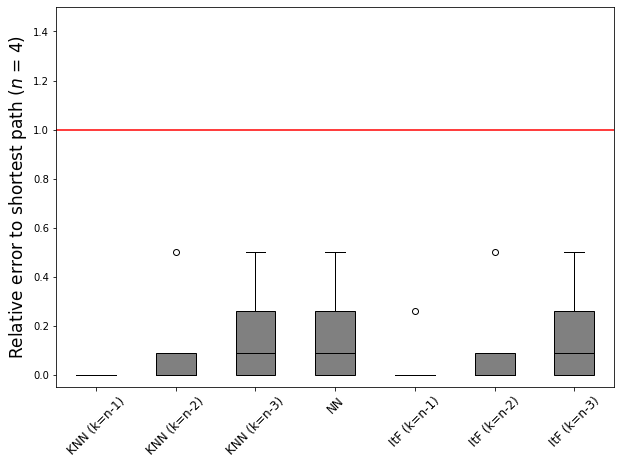

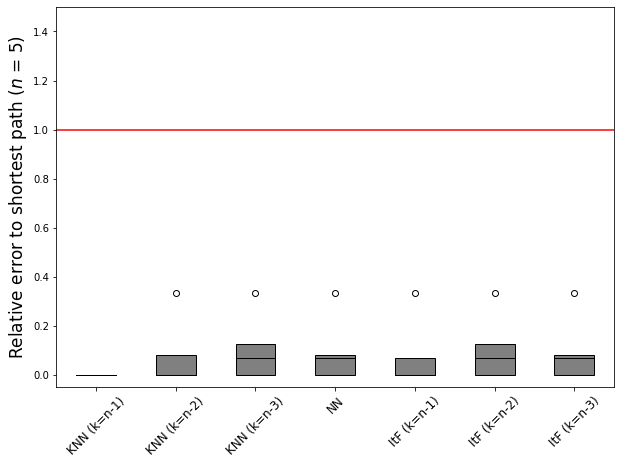

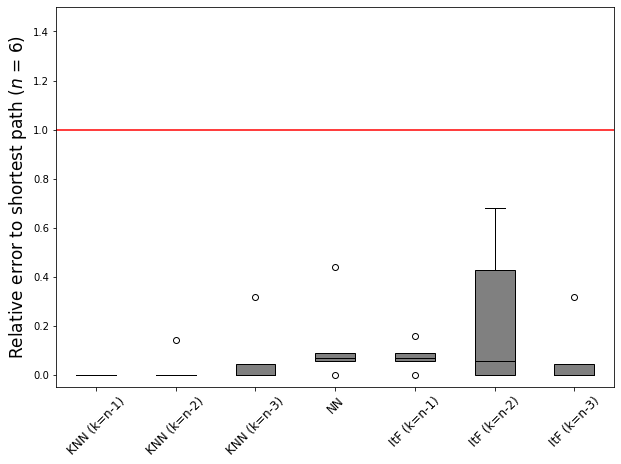

In [26]:
for j in range(nstart, n+1):
    labels = np.genfromtxt('errors_' + str(j) + '.csv', delimiter=',', max_rows=1, dtype='str')
    errors = np.genfromtxt('errors_' + str(j) + '.csv', delimiter=',', skip_header=1)


    fig = plt.figure(j, figsize=(10, 7))
    
    errors = abs(errors[:, (0,1,2,3,4,5,6)])
    labels = labels[[0,1,2,3,4,5,6]]
    
    
    plt.axhline(1, color='r')
    plt.boxplot(errors, patch_artist=True, boxprops=dict(facecolor='gray', color='k'), medianprops=dict(color='k'))
    
    plt.xticks(ticks = [1,2,3,4,5,6,7], labels=labels, rotation=45, fontsize=12)
    
    plt.ylabel("Relative error to shortest path ($n$ = " + str(j) + ")", fontsize=17)
    plt.ylim(top=1.5)
    
    #plt.savefig("errors_box_" + str(n) + ".pdf", dpi=300, bbox_inches="tight")
    
    plt.show()

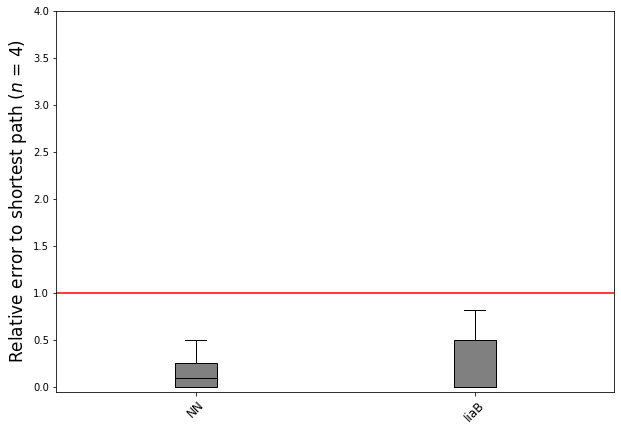

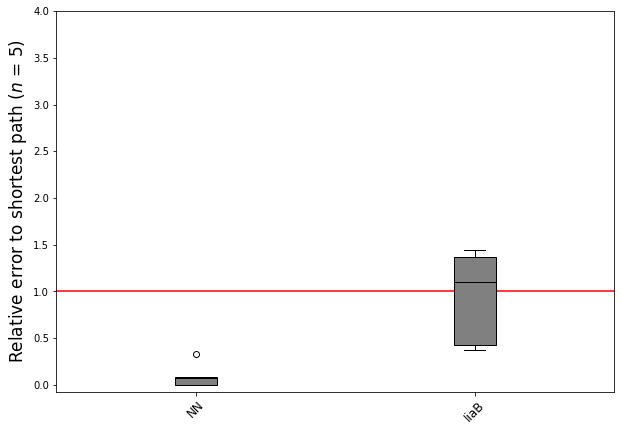

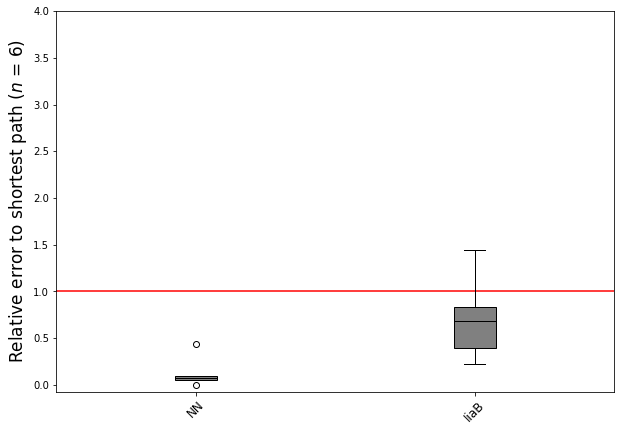

In [27]:
#model_names = ['KNN (k=n-1)', 'KNN (k=n-2)', 'KNN (k=n-3)', 'NN', 'ItF (k=n-1)', 'ItF (k=n-2)', 'ItF (k=n-3)', 'IiaB', ]
for j in range(nstart, n+1):
    labels = np.genfromtxt('tmperrors_' + str(j) + '.csv', delimiter=',', max_rows=1, dtype='str')
    errors = np.genfromtxt('tmperrors_' + str(j) + '.csv', delimiter=',', skip_header=1)

    fig = plt.figure(figsize =(10, 7))
    errors = abs(errors)

    errors = errors[:, (3,-1)]
    labels = labels[(3,-1),]

    plt.axhline(1, color='r')
    plt.boxplot(errors, patch_artist=True, boxprops=dict(facecolor='gray', color='k'), medianprops=dict(color='k'))
    plt.xticks(ticks = [1,2], labels=labels, rotation=45, fontsize=12)
    plt.ylabel("Relative error to shortest path ($n$ = " + str(j) + ")", fontsize=17)
    plt.ylim(top=4)
    #plt.savefig("errors_box_" + str(n) + "_w_iiab.pdf", dpi=300, bbox_inches="tight")
    
    plt.show()